## Projecting and interpolating low res tomography values to high res mesh

Note: This is only useful for annulus case but not regional spherical.
1. Import tomography on swarm
2. Project it to mesh variable
3. Now interpolate on high res mesh

In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer
import numpy as np
import os
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
# uw.matplotlib_inline()

In [2]:
# making output directory
outputPath = os.path.join(os.path.abspath("."),"tomo_project_cart/")

if uw.mpi.rank==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.mpi.barrier()

In [3]:
# turn on visualization
visualize_on = True

**Setup parameters**

In [4]:
"""
Resolution of the tomography
Note: Don't change these parameters
"""
xRes = 59  
yRes = 15
boxLength = 2.0
boxHeight = 1.0

In [5]:
# creating low res mesh to import tomography data
mesh_LRes            = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (xRes, yRes), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight),
                                 periodic    = [False, False] )

densityField_LRes 	 = mesh_LRes.add_variable( nodeDofCount=1 )

In [6]:
# all boundary nodes of low res mesh
outer_LRes 	= mesh_LRes.specialSets["MaxI_VertexSet"]
inner_LRes 	= mesh_LRes.specialSets["MinI_VertexSet"]
left_LRes 	= mesh_LRes.specialSets["MaxJ_VertexSet"]
right_LRes 	= mesh_LRes.specialSets["MinJ_VertexSet"]

In [7]:
# loading tomography data
model_density = np.genfromtxt('./output_dir/cart_profile_tomo_660.txt',dtype='float')
density_coords = model_density[:,[0,1]]

In [8]:
# creating swarm for the tomography data
swarm_density = uw.swarm.Swarm( mesh=mesh_LRes, particleEscape=True )
swarm_density_Coords = np.zeros((len(density_coords[:,0]),2))
swarm_density_Variable = swarm_density.add_variable(dataType='float', count=1)

swarm_density_Coords[:,0] = density_coords[:,0]
swarm_density_Coords[:,1] = density_coords[:,1]

swarm_density.add_particles_with_coordinates(swarm_density_Coords)

for index, coord in enumerate(model_density):
    swarm_density_Variable.data[index] = coord[2]/80


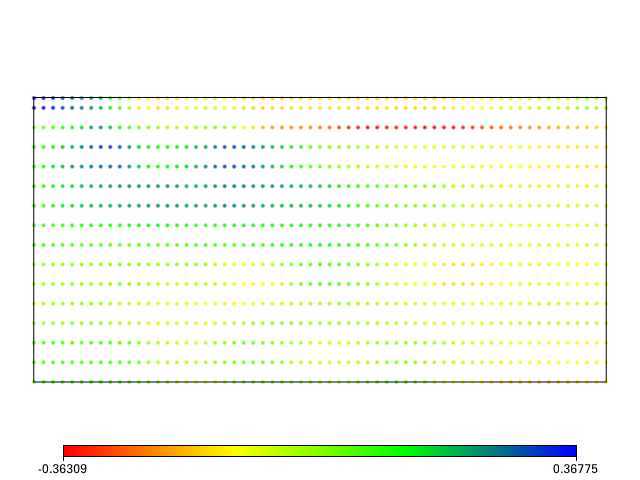

In [9]:
if visualize_on:
    fig_density = glucifer.Figure(axis=True)
    fig_density.append( glucifer.objects.Points(swarm=swarm_density, pointSize=5, 
                                          fn_colour=swarm_density_Variable, colourBar = True,
                                          colours="red yellow green blue"))
#     fig_density.append( glucifer.objects.Mesh(mesh_LRes, nodeNumbers=False) )
    fig_density.show()

In [10]:
#Projecting swarm values (tomography) onto mesh for interpolating 
projector = uw.utils.MeshVariable_Projection( densityField_LRes, swarm_density_Variable, type=0 )
projector.solve()

In [11]:
# saving mesh and low res tomography values
mesh_LResHnd = mesh_LRes.save(outputPath+'mesh_LRes'+'.h5')
den_LResHnd = densityField_LRes.save(outputPath+'densityField_LRes'+'.h5', mesh_LResHnd)
densityField_LRes.xdmf(outputPath+'density_LRes.xdmf', den_LResHnd, "densityField", mesh_LResHnd, "Mesh")


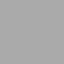

<IPython.core.display.Javascript object>

In [12]:
if visualize_on:
    fig_densityField = glucifer.Figure ( edgecolour="black" )
    fig_densityField.Surface( mesh_LRes, densityField_LRes, colours="red yellow green blue" )
    # fig_densityField.show()
    lv = fig_densityField.window()
    lv.rotate('y', 0)
    lv.redisplay()
    fig_densityField.save(outputPath+'densities_LRes.png', size=(1200, 800))

In [13]:
print("Minimum of original data: ", swarm_density_Variable.data.min())
print("Maximum of original data: ", swarm_density_Variable.data.max())
print("Minimum of interpolation: ", densityField_LRes.data.min())
print("Maximum of interpolation: ", densityField_LRes.data.max())

Minimum of original data:  -0.36309
Maximum of original data:  0.367754
Minimum of interpolation:  -0.256964374334
Maximum of interpolation:  0.366726866421


In [14]:
"""
Resolution of the model
Note: Change this values accordingly
"""
xRes = 64
yRes = 32
res = str(xRes)+'_'+str(yRes)

In [15]:
# creating mesh for the model resolution
mesh_HRes       	= uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (xRes, yRes), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight),
                                 periodic    = [False, False] )

densityField_HRes	= mesh_HRes.add_variable( nodeDofCount=1 )


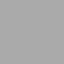

<IPython.core.display.Javascript object>

In [16]:
# checking interpolation using swarm
tomo_mesh = mesh_HRes.add_variable(nodeDofCount=1)
tomo_mesh.data[:] = swarm_density_Variable.evaluate(mesh_HRes.data)
fig = glucifer.Figure(figsize=(800,400))
fig.append(glucifer.objects.Surface(mesh_HRes,tomo_mesh, colourBar = True, colours="red yellow green blue")) 
# fig.show() 
lv = fig.window()
lv.rotate('y', 0)
lv.redisplay()


In [17]:
# stats on projection using swarm variable
diff_tomo = swarm_density_Variable.data - tomo_mesh.evaluate(swarm_density.data)
print("Max difference: ",np.max(diff_tomo))
print("Min difference: ",np.min(diff_tomo))
print(diff_tomo)

Max difference:  0.0278885258288
Min difference:  -0.0275914520025
[[  0.00000000e+00]
 [  1.30414664e-03]
 [  3.98369638e-03]
 [  6.29950166e-03]
 [  6.99972127e-03]
 [  9.16696119e-03]
 [  1.70690000e-02]
 [  2.78885258e-02]
 [  0.00000000e+00]
 [ -2.75914520e-02]
 [ -2.38320537e-02]
 [ -1.68856577e-02]
 [ -9.53325033e-03]
 [ -3.25209287e-03]
 [ -8.20704098e-05]
 [  0.00000000e+00]
 [ -1.71017648e-03]
 [ -1.99115906e-03]
 [  1.53717399e-03]
 [  7.64976141e-03]
 [  1.01204052e-02]
 [  7.49800205e-03]
 [  3.69591411e-03]
 [  0.00000000e+00]
 [  3.78000736e-04]
 [  1.01002806e-03]
 [  4.83982276e-04]
 [  7.12248683e-04]
 [  5.60378158e-04]
 [  2.04467836e-04]
 [  0.00000000e+00]
 [  1.45682678e-04]
 [  3.39270630e-04]
 [  4.35501337e-04]
 [  4.40822473e-04]
 [  3.31776180e-04]
 [  2.08497047e-04]
 [  2.00038118e-04]
 [  0.00000000e+00]
 [ -1.35499239e-04]
 [  1.24623508e-04]
 [  4.96466970e-04]
 [  8.23250413e-04]
 [  8.40839338e-04]
 [  5.36639786e-04]
 [  0.00000000e+00]
 [ -6.4281971

In [18]:
# stats on projection using Mesh variable (projecting from swarm to mesh variable)
diff_tomo1 = swarm_density_Variable.data - densityField_LRes.evaluate(swarm_density.data)
print("Max difference: ",np.max(diff_tomo1))
print("Min difference: ",np.min(diff_tomo1))
print(diff_tomo1)

Max difference:  0.0923412458584
Min difference:  -0.129965837882
[[  1.02687770e-03]
 [  9.05895640e-03]
 [  1.40976522e-02]
 [  1.42143793e-02]
 [  1.11998014e-02]
 [  1.15106824e-02]
 [  1.78276248e-02]
 [  2.39053682e-02]
 [  2.59072065e-02]
 [  2.52114989e-02]
 [  2.04264099e-02]
 [  1.36595881e-02]
 [  4.98887300e-03]
 [ -2.15999924e-03]
 [ -5.76865155e-03]
 [ -7.67001230e-03]
 [ -6.02794273e-03]
 [ -1.71630489e-03]
 [  4.92992923e-03]
 [  8.58454062e-03]
 [  5.33907959e-03]
 [  7.79083930e-04]
 [ -9.28716334e-04]
 [ -1.80934069e-03]
 [ -7.19995797e-04]
 [  1.01894368e-04]
 [ -6.15794071e-04]
 [ -3.54407728e-04]
 [  1.62616850e-04]
 [  4.55190079e-04]
 [  4.48126346e-04]
 [  3.51844748e-04]
 [  9.81704608e-06]
 [ -2.09247321e-04]
 [ -2.58837014e-04]
 [ -2.74918507e-04]
 [ -1.94254518e-04]
 [ -7.85858858e-05]
 [ -7.36296319e-05]
 [ -1.75499544e-04]
 [ -1.85722432e-04]
 [ -1.56810183e-05]
 [  4.95500118e-04]
 [  1.11646854e-03]
 [  1.76974967e-03]
 [  2.20291782e-03]
 [  2.34493325

In [19]:
# all boundary nodes of high res mesh
outer_HRes = mesh_HRes.specialSets["MaxI_VertexSet"]
inner_HRes = mesh_HRes.specialSets["MinI_VertexSet"]
left_HRes  = mesh_HRes.specialSets["MaxJ_VertexSet"]
right_HRes = mesh_HRes.specialSets["MinJ_VertexSet"]

In [20]:
# evaluating density in high res mesh
for node in range(mesh_HRes.nodesGlobal):
    pos = mesh_HRes.data[node]
    densityField_HRes.data[node] = densityField_LRes.evaluate(tuple(pos))


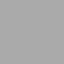

<IPython.core.display.Javascript object>

In [21]:
if visualize_on:
    fig_densityField_HRes = glucifer.Figure ( edgecolour="black" )
    fig_densityField_HRes.Surface( mesh_HRes, densityField_HRes, colours="red yellow green blue" )
    # fig_densityField.show()
    lv = fig_densityField_HRes.window()
    lv.rotate('y', 0)
    lv.redisplay()
    fig_densityField_HRes.save(outputPath+'densities_'+str(res)+'.png', size=(1200, 800))

In [22]:
print("Minimum of Low Resolution: ", densityField_LRes.data.min())
print("Maximum of Low Resolution: ", densityField_LRes.data.max())
print("Minimum of High Resolution: ", densityField_HRes.data.min())
print("Maximum of High Resolution: ", densityField_HRes.data.max())

Minimum of Low Resolution:  -0.256964374334
Maximum of Low Resolution:  0.366726866421
Minimum of High Resolution:  -0.249875787602
Maximum of High Resolution:  0.366726866421


In [23]:
# saving high res tomo
meshHnd = mesh_HRes.save(outputPath+'mesh_'+str(res)+'.h5')
den_HResHnd = densityField_HRes.save(outputPath+'densityField_'+str(res)+'.h5')
densityField_HRes.xdmf(outputPath+'densityField_'+str(res)+'.xdmf', den_HResHnd, "density", meshHnd, "mesh")